# Evaluation MIOST: 

In [1]:
import xarray as xr
import numpy
import hvplot.xarray
import pyinterp
import dask
import warnings
import xrft
import os
import sys
import pandas as pd
import logging
warnings.filterwarnings('ignore')
import numpy as np

##  1. Input files

##### libraries versions

In [2]:
print('xarray', xr.__version__)
print('numpy', numpy.__version__)
print('hvplot', hvplot.__version__)
print('pyinterp', pyinterp.__version__)
print('dask', dask.__version__)
print('logging', logging.__version__)
print('xrft', xrft.__version__)

xarray 2023.10.1
numpy 1.24.4
hvplot 0.8.4
pyinterp 2023.10.2
dask 2023.8.1
logging 0.5.1.2
xrft unknown


In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [4]:
sys.path.append('..')

In [5]:
from src.mod_regrid import *
from src.mod_eval import *
from src.mod_plot import *

### 1.1 Read Nature run SSH for mapping evaluation

In [6]:
if not os.path.exists('../ds_ref/ds_ref_1_20.nc'):
    print('ds_ref file not found...')
    print('download it...')
    os.makedirs('../ds_ref/',exist_ok=True)
    # Get nature run (it may take several minutes depending on your connection!!!!)
    !wget -O ds_ref_1_20.nc https://s3.eu-central-1.wasabisys.com/melody/data_challenge_Daniel_Guillaume/public/dc_ref/eNATL60-BLB002-daily-reg-1_20.nc
ds_ref = xr.open_dataset('./ds_ref_1_20.nc')

In [7]:
ds_ref

<xarray.Dataset>
Dimensions:       (lat: 1242, lon: 2803, time: 365)
Coordinates:
  * lat           (lat) float64 5.95 6.0 6.05 6.1 6.15 ... 67.85 67.9 67.95 68.0
  * lon           (lon) float64 -98.05 -98.0 -97.95 -97.9 ... 41.95 42.0 42.05
  * time          (time) datetime64[ns] 2012-10-01 2012-10-02 ... 2013-09-30
Data variables:
    mdt           (time, lat, lon) float64 dask.array<chunksize=(1, 156, 701), meta=np.ndarray>
    sla           (time, lat, lon) float64 dask.array<chunksize=(1, 1242, 2803), meta=np.ndarray>
    ssh           (time, lat, lon) float64 dask.array<chunksize=(1, 1242, 2803), meta=np.ndarray>
    ssh_norm      (time, lat, lon) float64 dask.array<chunksize=(1, 1242, 2803), meta=np.ndarray>
    ssh_variance  (time, lat, lon) float64 dask.array<chunksize=(1, 156, 701), meta=np.ndarray>
Attributes:
    About:    Created by SOSIE interpolation environement => https://github.c...
    Info:     Horizontal grid read in regulargrid_NATL60.nc / Source field re...

### 1.2 Read MIOST SSH reconstruction

In [8]:
if not os.path.exists('../ds_rec/ds_rec_miost_1_20.nc'):
    print('ds_rec file not found...')
    print('download it...')
    !wget -O ../ds_rec/ds_rec_miost_1_20.nc https://s3.eu-central-1.wasabisys.com/melody/data_challenge_Daniel_Guillaume/public/mappings/miost/1_20/mapping_miost_Natl60_1_20_alg_c2_h2ag_h2b_j3_s3a_s3b_component_geos_lwe_barotrop.nc

ds_rec = xr.open_dataset('../ds_rec/ds_rec_miost_1_20.nc')

In [9]:
ds_rec

<xarray.Dataset>
Dimensions:    (longitude: 2803, latitude: 1242, time: 365)
Coordinates:
  * longitude  (longitude) float64 -98.05 -98.0 -97.95 ... 41.95 42.0 42.05
  * latitude   (latitude) float64 5.95 6.0 6.05 6.1 ... 67.85 67.9 67.95 68.0
  * time       (time) datetime64[ns] 2012-10-01 2012-10-02 ... 2013-09-30
Data variables:
    sla        (time, latitude, longitude) float64 ...

In [10]:
ds_rec=ds_rec.rename({'longitude':'lon', 'latitude':'lat'})

In [11]:
ds_ref

<xarray.Dataset>
Dimensions:       (lat: 1242, lon: 2803, time: 365)
Coordinates:
  * lat           (lat) float64 5.95 6.0 6.05 6.1 6.15 ... 67.85 67.9 67.95 68.0
  * lon           (lon) float64 -98.05 -98.0 -97.95 -97.9 ... 41.95 42.0 42.05
  * time          (time) datetime64[ns] 2012-10-01 2012-10-02 ... 2013-09-30
Data variables:
    mdt           (time, lat, lon) float64 dask.array<chunksize=(1, 156, 701), meta=np.ndarray>
    sla           (time, lat, lon) float64 dask.array<chunksize=(1, 1242, 2803), meta=np.ndarray>
    ssh           (time, lat, lon) float64 dask.array<chunksize=(1, 1242, 2803), meta=np.ndarray>
    ssh_norm      (time, lat, lon) float64 dask.array<chunksize=(1, 1242, 2803), meta=np.ndarray>
    ssh_variance  (time, lat, lon) float64 dask.array<chunksize=(1, 156, 701), meta=np.ndarray>
Attributes:
    About:    Created by SOSIE interpolation environement => https://github.c...
    Info:     Horizontal grid read in regulargrid_NATL60.nc / Source field re...

In [12]:
ds_rec

<xarray.Dataset>
Dimensions:  (lon: 2803, lat: 1242, time: 365)
Coordinates:
  * lon      (lon) float64 -98.05 -98.0 -97.95 -97.9 ... 41.9 41.95 42.0 42.05
  * lat      (lat) float64 5.95 6.0 6.05 6.1 6.15 ... 67.8 67.85 67.9 67.95 68.0
  * time     (time) datetime64[ns] 2012-10-01 2012-10-02 ... 2013-09-30
Data variables:
    sla      (time, lat, lon) float64 ...

In [13]:
ds_rec = ds_rec.assign(ssh = ds_rec.sla + ds_ref.mdt)

# 2. Select periods (whole year, seasons) and domain of evaluation

In [14]:
##### Seasons for seasonal evaluation #####
Whole_year = slice(numpy.datetime64('2012-10-21') , numpy.datetime64('2013-09-10'))
Mid_autumn = slice(numpy.datetime64('2012-10-21') , numpy.datetime64('2012-11-30'))
Mid_winter = slice(numpy.datetime64('2013-02-01') , numpy.datetime64('2013-03-13'))
Mid_spring = slice(numpy.datetime64('2013-04-30') , numpy.datetime64('2013-06-09'))
Mid_summer = slice(numpy.datetime64('2013-07-11') , numpy.datetime64('2013-08-20'))

##### Domain for analysis : GF #####
lon_min = -64                                        # domain min lon
lon_max = -49                                       # domain max lon
lat_min = 29                                         # domain min lat
lat_max = 44                                        # domain max lat

##### Domain for analysis : GRE #####
# lon_min = -39                                        # domain min lon
# lon_max = -24                                       # domain max lon
# lat_min = 49                                         # domain min lat
# lat_max = 64                                        # domain max lat

##### Domain for analysis : MAD #####
# lon_min = -27                                        # domain min lon
# lon_max = -12                                       # domain max lon
# lat_min = 29                                         # domain min lat
# lat_max = 44                                        # domain max lat

In [15]:
## whole year
ds_ref_whole_year = ds_ref.sel(time=Whole_year , lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max), drop=True)
ds_rec_whole_year = ds_rec.sel(time=Whole_year , lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max), drop=True)
## seasons
ds_ref_seasonal = [ds_ref.sel(time=Mid_autumn , lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max), drop=True),
                   ds_ref.sel(time=Mid_winter , lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max), drop=True),
                   ds_ref.sel(time=Mid_spring , lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max), drop=True),
                   ds_ref.sel(time=Mid_summer , lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max), drop=True)]

ds_rec_seasonal = [ds_rec.sel(time=Mid_autumn , lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max), drop=True),
                   ds_rec.sel(time=Mid_winter , lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max), drop=True),
                   ds_rec.sel(time=Mid_spring , lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max), drop=True),
                   ds_rec.sel(time=Mid_summer , lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max), drop=True)]

In [16]:
date_seasonal_ref=np.asarray([ds_ref_seasonal[j].time.size for j in range(len(ds_ref_seasonal))])
date_seasonal_rec=np.asarray([ds_rec_seasonal[j].time.size for j in range(len(ds_rec_seasonal))])
if not (np.all(date_seasonal_ref == date_seasonal_ref[0]) and np.all(date_seasonal_rec == date_seasonal_rec[0])):
    raise ValueError('Every seasonal datasets must have the same size along time axis ')

In [17]:
ds_rec_whole_year

<xarray.Dataset>
Dimensions:  (lon: 300, lat: 300, time: 325)
Coordinates:
  * lon      (lon) float64 -63.95 -63.9 -63.85 -63.8 ... -49.1 -49.05 -49.0
  * lat      (lat) float64 29.05 29.1 29.15 29.2 29.25 ... 43.85 43.9 43.95 44.0
  * time     (time) datetime64[ns] 2012-10-21 2012-10-22 ... 2013-09-10
Data variables:
    sla      (time, lat, lon) float64 ...
    ssh      (time, lat, lon) float64 dask.array<chunksize=(1, 6, 19), meta=np.ndarray>

In [18]:
ds_ref_whole_year

<xarray.Dataset>
Dimensions:       (lat: 300, lon: 300, time: 325)
Coordinates:
  * lat           (lat) float64 29.05 29.1 29.15 29.2 ... 43.85 43.9 43.95 44.0
  * lon           (lon) float64 -63.95 -63.9 -63.85 -63.8 ... -49.1 -49.05 -49.0
  * time          (time) datetime64[ns] 2012-10-21 2012-10-22 ... 2013-09-10
Data variables:
    mdt           (time, lat, lon) float64 dask.array<chunksize=(1, 6, 19), meta=np.ndarray>
    sla           (time, lat, lon) float64 dask.array<chunksize=(1, 300, 300), meta=np.ndarray>
    ssh           (time, lat, lon) float64 dask.array<chunksize=(1, 300, 300), meta=np.ndarray>
    ssh_norm      (time, lat, lon) float64 dask.array<chunksize=(1, 300, 300), meta=np.ndarray>
    ssh_variance  (time, lat, lon) float64 dask.array<chunksize=(1, 6, 19), meta=np.ndarray>
Attributes:
    About:    Created by SOSIE interpolation environement => https://github.c...
    Info:     Horizontal grid read in regulargrid_NATL60.nc / Source field re...

##  3. Evaluation MIOST

In [19]:
output_directory = '../results/'
if not os.path.exists(output_directory):
    os.mkdir(output_directory) 

In [20]:
!pip install tabulate

### 3.1 Whole year evaluation

In [21]:
# Eval
rmse_t, rmse_xy, leaderboard_nrmse, leaderboard_nrmse_std = rmse_based_scores(ds_rec_whole_year, ds_ref_whole_year)
psd, leaderboard_psds_score, leaderboard_psdt_score  = psd_based_scores(ds_rec_whole_year, ds_ref_whole_year)


filename_rmse_t = output_directory + 'rmse_t_miost_ssh_reconstruction_2012-10-21-2013-09-10_alg_c2_h2ag_h2b_j3_s3a_s3b.nc'
filename_rmse_xy = output_directory + 'rmse_xy_miost_ssh_reconstruction_2012-10-21-2013-09-10_alg_c2_h2ag_h2b_j3_s3a_s3b.nc'
filename_psd = output_directory + 'psd_miost_ssh_reconstruction_2012-10-21-2013-09-10_alg_c2_h2ag_h2b_j3_s3a_s3b.nc'
# Save results
# rmse_t.to_netcdf(filename_rmse_t)
# rmse_xy.to_netcdf(filename_rmse_xy)
psd.name = 'psd_score'
# psd.to_netcdf(filename_psd)

# Print leaderboard
data = [['MIOST', 
         leaderboard_nrmse, 
         leaderboard_nrmse_std, 
         leaderboard_psds_score, 
         leaderboard_psdt_score,
        'GF',
        'eval_miost.ipynb']]

Leaderboard = pd.DataFrame(data, 
                           columns=['Method', 
                                    "µ(RMSE) ", 
                                    "σ(RMSE)", 
                                    'λx (degree)', 
                                    'λt (days)', 
                                    'Domain',
                                    'Reference'])
print("Summary of the leaderboard metrics, over the whole year:")
Leaderboard
print(Leaderboard.to_markdown())

INFO:root:     Compute RMSE-based scores...
INFO:root:          => Leaderboard SSH RMSE score = 0.926
INFO:root:          Error variability = 0.011 (temporal stability of the mapping error)
INFO:root:     Compute PSD-based scores...


[########################################] | 100% Completed | 4.56 sms
[########################################] | 100% Completed | 1.43 sms


INFO:root:          => Leaderboard Spectral score = 1.32 (degree lon)
INFO:root:          => shortest temporal wavelength resolved = 13.39 (days)


Summary of the leaderboard metrics, over the whole year:
|    | Method   |   µ(RMSE)  |   σ(RMSE) |   λx (degree) |   λt (days) | Domain   | Reference        |
|---:|:---------|-----------:|----------:|--------------:|------------:|:---------|:-----------------|
|  0 | MIOST    |      0.926 |     0.011 |         1.315 |       13.39 | GF       | eval_miost.ipynb |


In [22]:
rmse_t.hvplot.line(x='time', y='rmse_t', ylim=(0, 1), cmap=['royalblue'], title='RMSE-based scores')

:Curve   [time]   (rmse_t)

The figure above shows the time series of the RMSE scores for the reconstruction of SSH.

In [23]:
rmse_xy.hvplot.contourf(x='lon', y='lat', levels=list(numpy.arange(0.,0.5, 0.05)), height=300, width=400, cmap='Reds', subplots=True, clabel='RMSE[m]')

:Polygons   [lon,lat]   (rmse_xy)

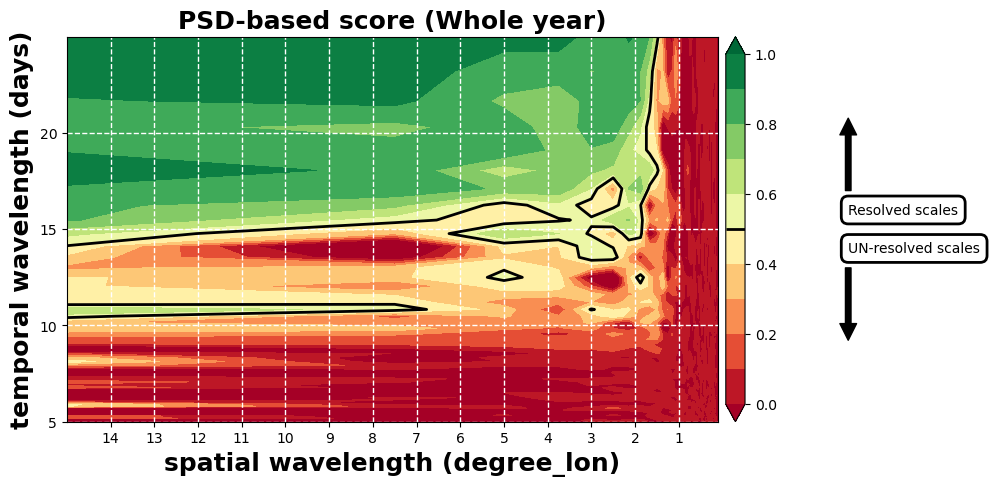

In [24]:
psd = psd.expand_dims({'experiment':1})
psd['experiment'] = ['Whole year']
plot_psd_score(psd,time_min=5,time_max=25, step_time=5)

The PSD-based score evaluates the spatio-temporal scales resolved in mapping (green area). Resolution limits can be defined as the contour where the PSD score = 0.5, black contour in the figure (i.e. space-time scales where the reconstruction SSH error level is 2 times lower than the real SSH signal). 

### 3.2 Seasonal evaluation 

In [25]:
Seasons = ['Mid_autumn','Mid_winter','Mid_spring','Mid_summer']
Leaderboard_seasonal = []
Psd_seasonal = []
Data = []
Method = ['MIOST','','','']
Domain = ['GF','','','']
Reference = ['eval_miost.ipynb','','','']

for i,ds_ref, ds_rec in zip(np.arange(len(Seasons)),ds_ref_seasonal, ds_rec_seasonal): 
    # Eval
    rmse_t, rmse_xy, leaderboard_nrmse, leaderboard_nrmse_std = rmse_based_scores(ds_rec, ds_ref)
    psd, leaderboard_psds_score, leaderboard_psdt_score  = psd_based_scores(ds_rec, ds_ref)


    filename_rmse_t = output_directory + 'rmse_t_miost_ssh_reconstruction_2012-10-21-2013-09-10_alg_c2_h2ag_h2b_j3_s3a_s3b.nc'
    filename_rmse_xy = output_directory + 'rmse_xy_miost_ssh_reconstruction_2012-10-21-2013-09-10_alg_c2_h2ag_h2b_j3_s3a_s3b.nc'
    filename_psd = output_directory + 'psd_miost_ssh_reconstruction_2012-10-21-2013-09-10_alg_c2_h2ag_h2b_j3_s3a_s3b.nc'
    # Save results
    # rmse_t.to_netcdf(filename_rmse_t)
    # rmse_xy.to_netcdf(filename_rmse_xy)
    psd.name = 'psd_score'
    # psd.to_netcdf(filename_psd)

    # Print leaderboard
    Data.append([Method[i],
             Seasons[i],
             leaderboard_nrmse, 
             leaderboard_nrmse_std, 
             leaderboard_psds_score, 
             leaderboard_psdt_score,
             Domain[i],
             Reference[i]])

    Psd_seasonal.append(psd)
    
Leaderboard_seasonal=pd.DataFrame(Data, 
                            columns=(['Method',
                                     'Season',
                                     "µ(RMSE) ", 
                                     "σ(RMSE)", 
                                     'λx (degree)', 
                                     'λt (days)', 
                                     'Domain',
                                     'Reference']))
    
print("Summary of the leaderboard metrics, for each season:")
print(Leaderboard_seasonal.to_markdown())

INFO:root:     Compute RMSE-based scores...
INFO:root:          => Leaderboard SSH RMSE score = 0.941
INFO:root:          Error variability = 0.008 (temporal stability of the mapping error)
INFO:root:     Compute PSD-based scores...


[########################################] | 100% Completed | 1.52 sms
[########################################] | 100% Completed | 1.13 sms


INFO:root:          => Leaderboard Spectral score = 1.37 (degree lon)
INFO:root:          => shortest temporal wavelength resolved = 10.22 (days)
INFO:root:     Compute RMSE-based scores...
INFO:root:          => Leaderboard SSH RMSE score = 0.926
INFO:root:          Error variability = 0.007 (temporal stability of the mapping error)
INFO:root:     Compute PSD-based scores...


[########################################] | 100% Completed | 1.53 sms
[########################################] | 100% Completed | 1.11 sms


INFO:root:          => Leaderboard Spectral score = 1.43 (degree lon)
INFO:root:          => shortest temporal wavelength resolved = 8.15 (days)
INFO:root:     Compute RMSE-based scores...
INFO:root:          => Leaderboard SSH RMSE score = 0.921
INFO:root:          Error variability = 0.011 (temporal stability of the mapping error)
INFO:root:     Compute PSD-based scores...


[########################################] | 100% Completed | 1.60 sms
[########################################] | 100% Completed | 1.03 sms


INFO:root:          => Leaderboard Spectral score = 1.32 (degree lon)
INFO:root:          => shortest temporal wavelength resolved = 10.44 (days)
INFO:root:     Compute RMSE-based scores...
INFO:root:          => Leaderboard SSH RMSE score = 0.923
INFO:root:          Error variability = 0.007 (temporal stability of the mapping error)
INFO:root:     Compute PSD-based scores...


[########################################] | 100% Completed | 1.43 sms
[########################################] | 100% Completed | 1.15 sms


INFO:root:          => Leaderboard Spectral score = 1.57 (degree lon)
INFO:root:          => shortest temporal wavelength resolved = 10.04 (days)


Summary of the leaderboard metrics, for each season:
|    | Method   | Season     |   µ(RMSE)  |   σ(RMSE) |   λx (degree) |   λt (days) | Domain   | Reference        |
|---:|:---------|:-----------|-----------:|----------:|--------------:|------------:|:---------|:-----------------|
|  0 | MIOST    | Mid_autumn |      0.941 |     0.008 |         1.367 |       10.22 | GF       | eval_miost.ipynb |
|  1 |          | Mid_winter |      0.926 |     0.007 |         1.425 |        8.15 |          |                  |
|  2 |          | Mid_spring |      0.921 |     0.011 |         1.324 |       10.44 |          |                  |
|  3 |          | Mid_summer |      0.923 |     0.007 |         1.575 |       10.04 |          |                  |


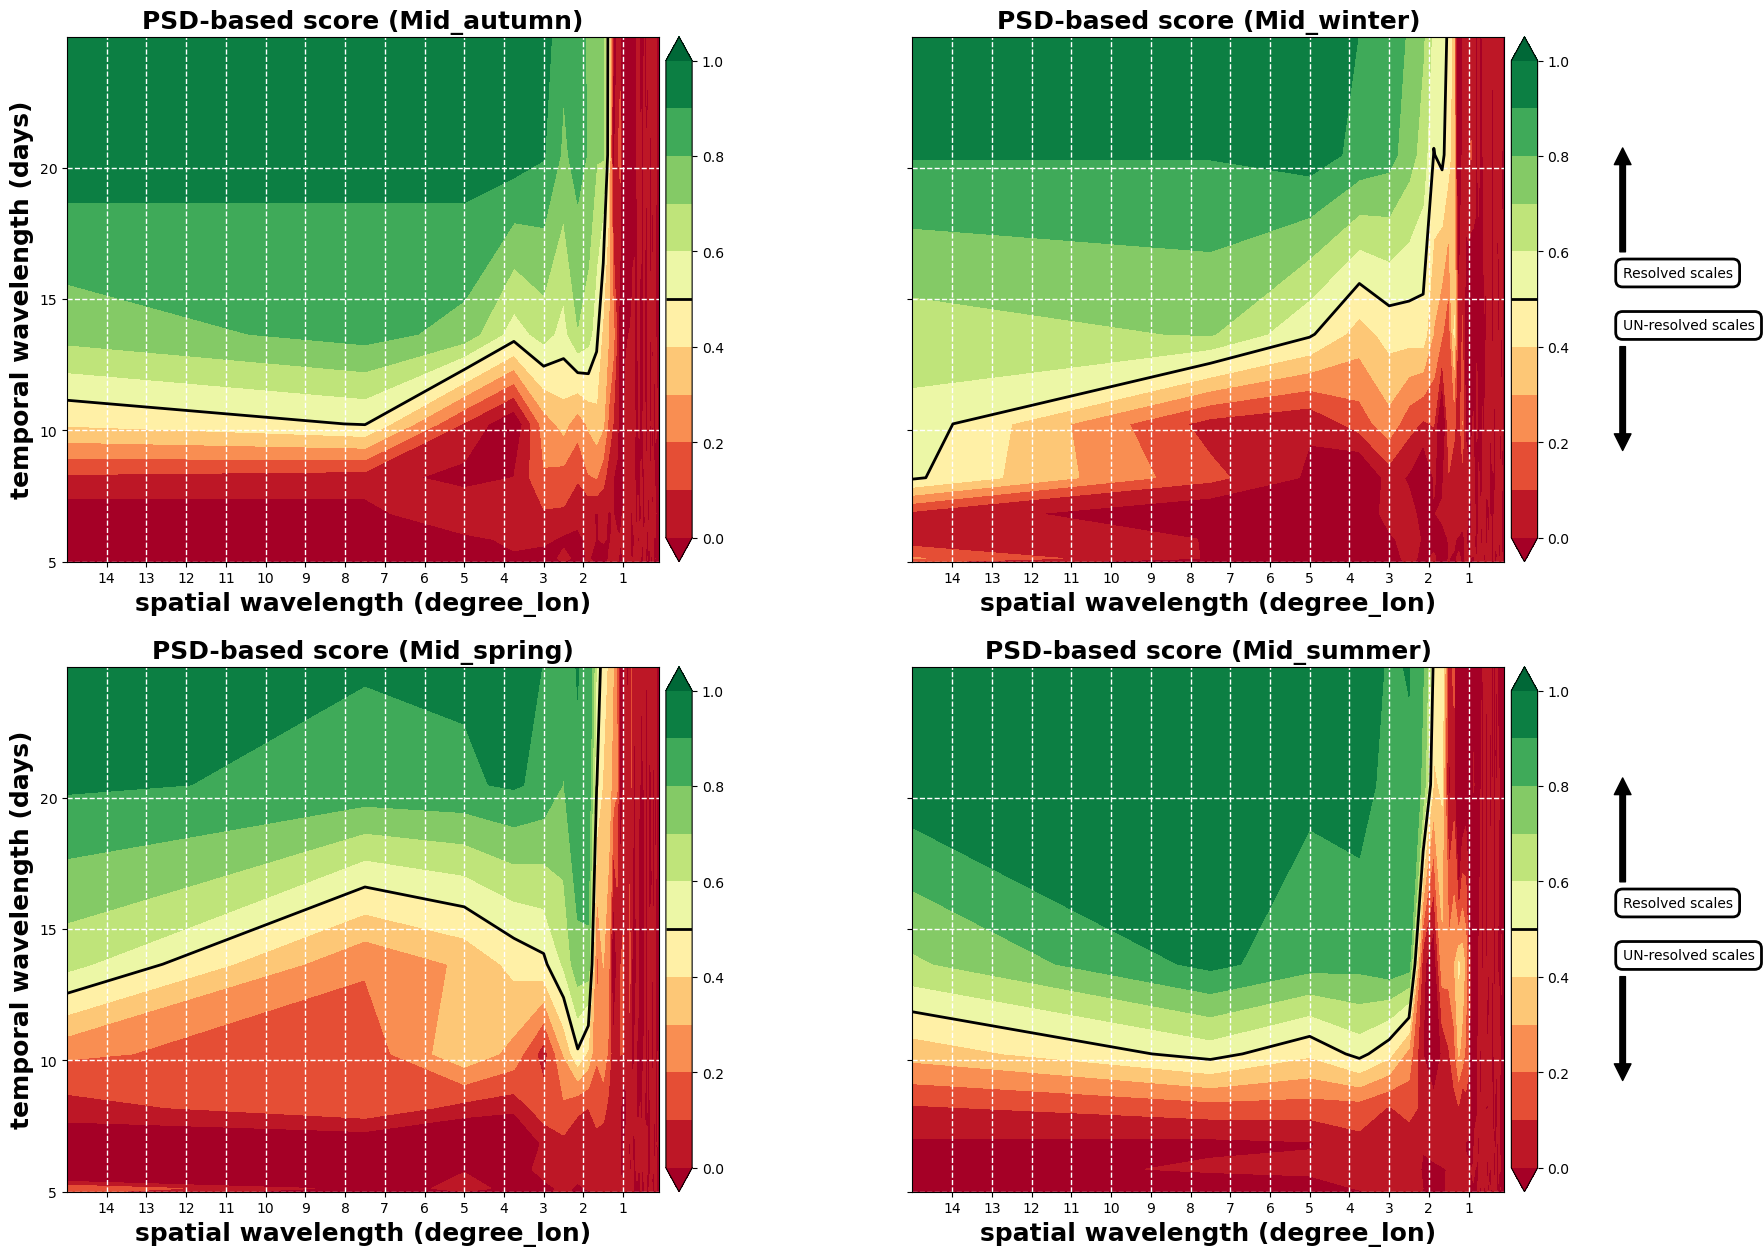

In [26]:
psd_concat = xr.concat((Psd_seasonal[0], Psd_seasonal[1], Psd_seasonal[2], Psd_seasonal[3]), dim='experiment')
psd_concat['experiment'] = ["Mid_autumn", "Mid_winter", "Mid_spring", "Mid_summer"] 
plot_psd_score_seasonal(psd_concat, time_min=5,time_max=25, step_time=5)